In [1]:
# !git init .
# !git remote add origin https://github.com/kashparty/STP-GSR.git
# !git pull origin discriminator

In [2]:
# !pip install -r requirements.txt

# 3-Fold Cross-Validation

In [ ]:
import os
import hydra
import torch
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import KFold
from hydra import compose, initialize

from src.train import train, eval
from src.plot_utils import plot_adj_matrices
from src.dataset import load_dataset

# Check if CUDA available and select device
device = "cuda" if torch.cuda.is_available() else "cpu"

with initialize(version_base=None, config_path="configs"):
    config = compose(config_name="experiment")

torch.cuda.empty_cache()

if torch.cuda.is_available():
    print("Running on GPU")
else:
    print("Running on CPU")

# Define K-fold cross-validation strategy using parameters from config
kf = KFold(n_splits=config.experiment.kfold.n_splits, 
            shuffle=config.experiment.kfold.shuffle, 
            random_state=config.experiment.kfold.random_state)

# Initialise folder structure for this run
base_dir = config.experiment.base_dir
model_name = config.model.name
dataset_type = config.dataset.name
run_name = config.experiment.run_name
run_dir = f'{base_dir}/{model_name}/{dataset_type}/{run_name}/'

# Load source and target datasets
source_data, target_data = load_dataset(config)

/vol/bitbucket/akm20/conda/envs/DGLCW2/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/vol/bitbucket/akm20/conda/envs/DGLCW2/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Running on GPU


In [ ]:
def main():
    res_dirs = []

    # Iterate over each fold for training and validation
    for fold, (train_idx, val_idx) in enumerate(kf.split(source_data)):
        print(f"Training Fold {fold+1}/3")

        # Initialise results directory for current fold
        res_dir = f'{run_dir}fold_{fold+1}/'
        res_dirs.append(res_dir)
        if not os.path.exists(res_dir):
            os.makedirs(res_dir)

        # Separate training and validation data for this fold
        source_data_train = [source_data[i] for i in train_idx]
        target_data_train = [target_data[i] for i in train_idx]
        source_data_val = [source_data[i] for i in val_idx]
        target_data_val = [target_data[i] for i in val_idx]

        # Train model for this fold
        train_output = train(config, 
                              source_data_train, 
                              target_data_train,
                              source_data_val,
                              target_data_val, 
                              res_dir)

        # Evaluate model for this fold
        eval_output, eval_loss = eval(config, 
                                      train_output['model'], 
                                      source_data_val, 
                                      target_data_val, 
                                      train_output['criterion_L1'])

        # Print final validation loss for this fold
        print(f"Final Validation Loss (Target): {eval_loss}")

        # Save evaluation results, source, and target matrices for this fold
        np.save(f'{res_dir}/eval_output.npy', np.array(eval_output))
        np.save(f'{res_dir}/source.npy', np.array([s['mat'] for s in source_data_val]))
        np.save(f'{res_dir}/target.npy', np.array([t['mat'] for t in target_data_val]))


        # Plot predictions for a random sample
        idx = 6
        source_mat_test = source_data_val[idx]['mat']
        target_mat_test = target_data_val[idx]['mat']
        eval_output_t = eval_output[idx]

        plot_adj_matrices(source_mat_test, 
                          target_mat_test, 
                          eval_output_t, 
                          idx, 
                          res_dir, 
                          file_name=f'eval_sample{idx}')

    return res_dirs

# Execute the main function to perform 3-fold cross validation
res_dirs = main()

# Evaluating each fold

Processing fold from: results/stp_gsr/train/run4/fold_1/


100%|██████████| 56/56 [38:06<00:00, 40.82s/it]


Processing fold from: results/stp_gsr/train/run4/fold_2/


100%|██████████| 56/56 [38:13<00:00, 40.96s/it]


Processing fold from: results/stp_gsr/train/run4/fold_3/


100%|██████████| 55/55 [37:17<00:00, 40.68s/it]


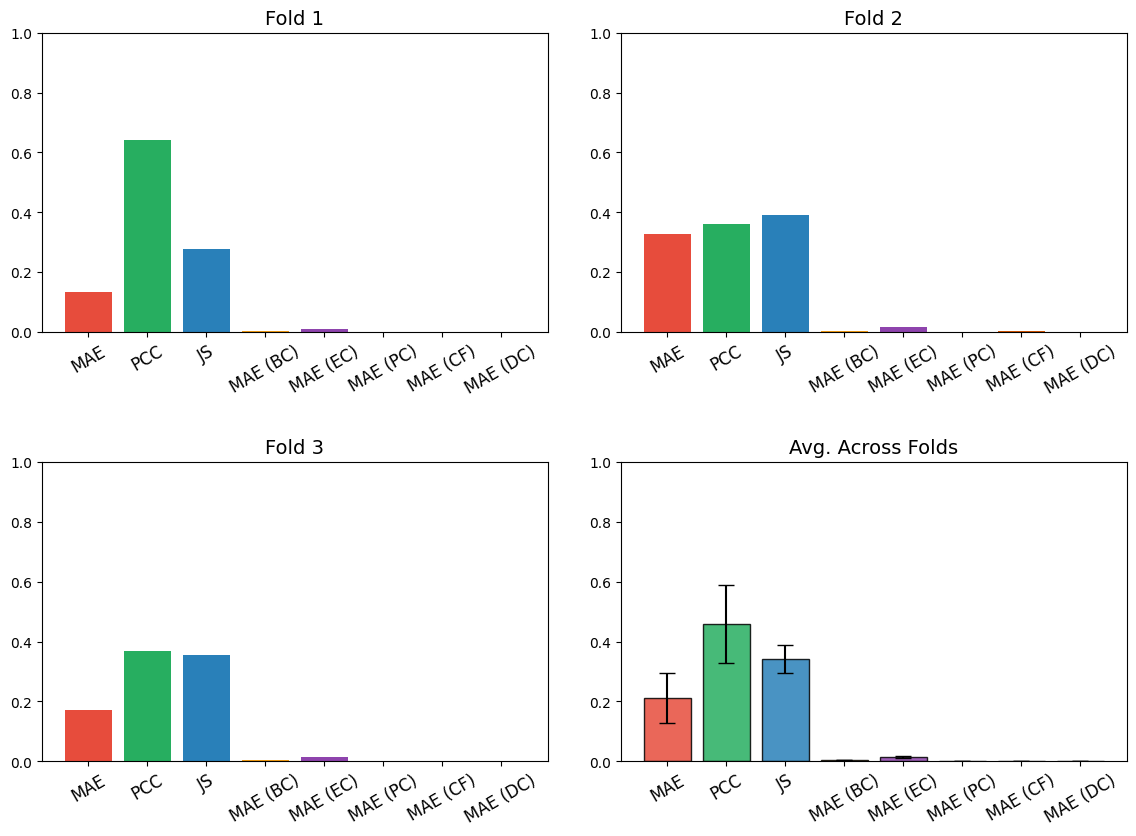

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
from scipy.spatial.distance import jensenshannon
from hydra import compose, initialize
from tqdm import tqdm
from src.matrix_vectorizer import MatrixVectorizer
import networkx as nx

# Load experiment configuration using Hydra
with initialize(version_base=None, config_path="configs"):
    config = compose(config_name="experiment")

# Define metrics to store results for each fold
metrics = ["MAE", "PCC", "JS", "MAE (BC)", "MAE (EC)", "MAE (PC)", "MAE (CF)", "MAE (DC)"]
fold_results = {m: [] for m in metrics}

# List of directories containing results for each fold
res_dirs = [f'{run_dir}fold_1/', f'{run_dir}fold_2/', f'{run_dir}fold_3/']

def safe_assign(func, *args, default=None, **kwargs):
    try:
        return func(*args, **kwargs)
    except Exception:
        return default

# Compute metrics for each fold
for res_dir in res_dirs:
    print(f"Processing fold from: {res_dir}")

    # Load predicted and true matrices
    pred_matrices = np.load(f'{res_dir}/eval_output.npy', allow_pickle=True)
    true_matrices = np.load(f'{res_dir}/target.npy', allow_pickle=True)

    # Initialise metric-specific lists
    mae_bc, mae_ec, mae_pc, mae_cf, mae_dc = [], [], [], [], []
    pred_1d_list, gt_1d_list = [], []

    for i in tqdm(range(len(pred_matrices))):
        # Ensure numerical stability by replacing zeros with very small weights
        pred_matrices[i] = np.where(
            pred_matrices[i] == 0,
            1e-10 * np.ones_like(pred_matrices[i]),
            pred_matrices[i]
        )
        true_matrices[i] = np.where(
            true_matrices[i] == 0,
            1e-10 * np.ones_like(true_matrices[i]),
            true_matrices[i]
        )

        # Create graphs from adjacency matrices
        pred_graph = nx.from_numpy_array(pred_matrices[i])
        gt_graph = nx.from_numpy_array(true_matrices[i])

        # Compute graph metrics (centrality measures)
        pred_bc = safe_assign(nx.betweenness_centrality, pred_graph, weight="weight")
        pred_ec = safe_assign(nx.eigenvector_centrality, pred_graph, weight="weight")
        pred_pc = safe_assign(nx.pagerank, pred_graph, weight="weight")
        pred_cf = safe_assign(nx.current_flow_betweenness_centrality, pred_graph, weight="weight")

        pred_dc = [val for (_, val) in sorted(pred_graph.degree(weight="weight"), key=lambda pair: pair[0])]
        
        gt_bc = safe_assign(nx.betweenness_centrality, gt_graph, weight="weight")
        gt_ec = safe_assign(nx.eigenvector_centrality, gt_graph, weight="weight")
        gt_pc = safe_assign(nx.pagerank, gt_graph, weight="weight")
        gt_cf = safe_assign(nx.current_flow_betweenness_centrality, gt_graph, weight="weight")
        gt_dc = [val for (_, val) in sorted(gt_graph.degree(weight="weight"), key=lambda pair: pair[0])]

        # Calculate MAE for each metric if both predictions and ground truth are available
        if pred_bc is not None and gt_bc is not None:
            mae_bc.append(mean_absolute_error(list(pred_bc.values()), list(gt_bc.values())))
        if pred_ec is not None and gt_ec is not None:
            mae_ec.append(mean_absolute_error(list(pred_ec.values()), list(gt_ec.values())))
        if pred_pc is not None and gt_pc is not None:
            mae_pc.append(mean_absolute_error(list(pred_pc.values()), list(gt_pc.values())))
        if pred_cf is not None and gt_cf is not None:
            mae_cf.append(mean_absolute_error(list(pred_cf.values()), list(gt_cf.values())))
        if pred_dc is not None and gt_dc is not None:
            mae_dc.append(mean_absolute_error(pred_dc, gt_dc))

        # Vectorise adjacency matrices for fold-level metrics
        pred_1d_list.append(MatrixVectorizer.vectorize(pred_matrices[i]))
        gt_1d_list.append(MatrixVectorizer.vectorize(true_matrices[i]))

    # Aggregate per-fold results
    pred_1d = np.concatenate(pred_1d_list)
    gt_1d = np.concatenate(gt_1d_list)

    fold_results["MAE"].append(mean_absolute_error(pred_1d, gt_1d))
    fold_results["PCC"].append(pearsonr(pred_1d, gt_1d)[0])
    fold_results["JS"].append(jensenshannon(pred_1d, gt_1d))
    fold_results["MAE (BC)"].append(np.mean(mae_bc))
    fold_results["MAE (EC)"].append(np.mean(mae_ec))
    fold_results["MAE (PC)"].append(np.mean(mae_pc))
    fold_results["MAE (CF)"].append(np.mean(mae_cf))
    fold_results["MAE (DC)"].append(np.mean(mae_dc))


[(0, 102.46778955344321), (1, 89.61674954326836)]


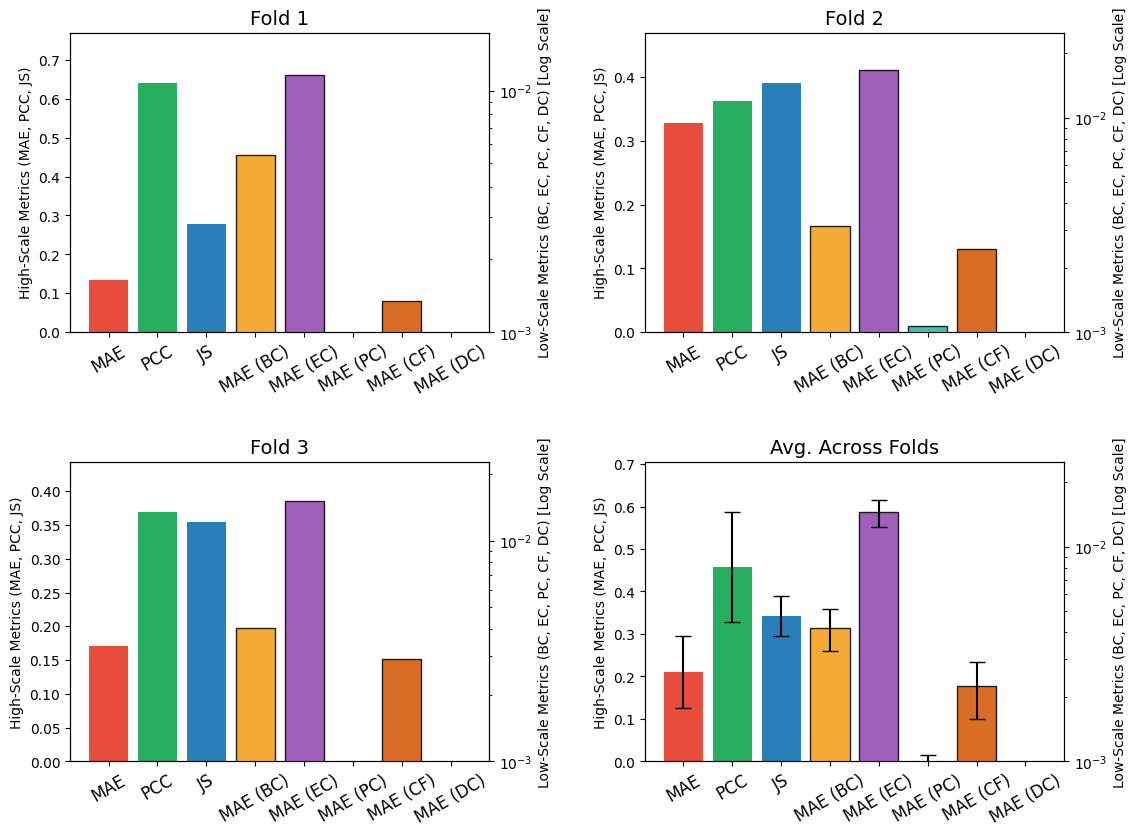

In [ ]:
plt.rcParams.update({"font.size": 14})  # Update font size for better readability in plots

# Compute mean and standard deviation for each metric across folds
means = [np.mean(fold_results[m]) for m in metrics]
stds = [np.std(fold_results[m]) for m in metrics]

# Define custom colors for metrics visualisation
custom_colors = ['#E74C3C', '#27AE60', '#2980B9', '#F39C12', '#8E44AD', '#1ABC9C', '#D35400', '#3498DB']

# Separate metrics into two groups split by magnitude
high_scale_metrics = ["MAE", "PCC", "JS"]  
low_scale_metrics = ["MAE (BC)", "MAE (EC)", "MAE (PC)", "MAE (CF)", "MAE (DC)"]  

# Get indices for the two groups of metrics
high_indices = [metrics.index(m) for m in high_scale_metrics]
low_indices = [metrics.index(m) for m in low_scale_metrics]

# Initialise subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 9))
axes = axes.flatten()
label_rotation = 30
hatch_pattern = "//"  # Hatch pattern for bars representing low-scale metrics

def plot_dual_axis(ax, values, title=""):
    """Plot bar charts for metrics with dual Y-axes for different scales"""
    ax2 = ax.twinx()

    # Split values into high-scale and low-scale metrics
    high_values = [values[i] for i in high_indices]
    low_values = [values[i] for i in low_indices]

    # Plot high-scale metrics on left Y-axis
    bars_high = ax.bar(
        [metrics[i] for i in high_indices], high_values, 
        color=[custom_colors[i] for i in high_indices],
        edgecolor="black",
        alpha=0.9
    )

    # Plot low-scale metrics on right Y-axis
    bars_low = ax2.bar(
        [metrics[i] for i in low_indices], low_values, 
        color=[custom_colors[i] for i in low_indices], 
        edgecolor="black",
        alpha=0.85
    )

    for bar in bars_low:
        bar.set_hatch(hatch_pattern)

    # Add title, labels, and configure y-axis scaling
    ax.set_title(title, fontsize=14)
    ax.set_ylim(0, 0.8)
    ax2.set_yscale("log")
    ax2.set_ylim(1e-4, 1e2)
    ax.tick_params(axis='x', rotation=label_rotation, labelsize=12)
    ax.set_ylabel("MAE, PCC, JS")
    ax2.set_ylabel("BC, EC, PC, CF, DC [Log]")
    
    ax.grid(True, linestyle="--", alpha=0.6)  # Add grid

# Plot metrics for each fold
for i, res_dir in enumerate(res_dirs):
    temp = [fold_results[m][i] for m in metrics]
    plot_dual_axis(axes[i], temp, title=f'Fold {i+1}')

def plot_avg_with_error(ax):
    """Plot average values across folds with error bars"""
    ax2 = ax.twinx()

    # Split means and standard deviations into high-scale and low-scale metrics
    means_high = [means[i] for i in high_indices]
    means_low = [means[i] for i in low_indices]
    stds_high = [stds[i] for i in high_indices]
    stds_low = [stds[i] for i in low_indices]

    # Plot high-scale metrics with error bars
    bars_high = ax.bar(
        [metrics[i] for i in high_indices], means_high, 
        yerr=stds_high, capsize=8, 
        color=[custom_colors[i] for i in high_indices],
        edgecolor='black', alpha=0.9,
        error_kw={"elinewidth": 1.5, "markeredgewidth": 1.5}
    )

    # Plot low-scale metrics with error bars
    bars_low = ax2.bar(
        [metrics[i] for i in low_indices], means_low, 
        yerr=stds_low, capsize=8, 
        color=[custom_colors[i] for i in low_indices], 
        edgecolor='black', alpha=0.85,
        error_kw={"elinewidth": 1.5, "markeredgewidth": 1.5}
    )

    for bar in bars_low:
        bar.set_hatch(hatch_pattern)

    # Add title, labels, and configure y-axis scaling
    ax.set_title('Average Across Folds', fontsize=14)
    ax.set_ylim(0, 0.8)
    ax2.set_yscale("log")
    ax2.set_ylim(1e-4, 1e2)
    ax.tick_params(axis='x', rotation=label_rotation, labelsize=12)
    ax.set_ylabel("MAE, PCC, JS")
    ax2.set_ylabel("BC, EC, PC, CF, DC [Log]")
    
    ax.grid(True, linestyle="--", alpha=0.6)  # Add grid

# Plot the average metrics across folds with error bars
plot_avg_with_error(axes[3])

# Overall title for the figure
fig.suptitle("DAT-GSR, Performance Metrics Across Folds", fontsize=16, fontweight='bold')

plt.tight_layout(pad=2.5)
plt.subplots_adjust(top=0.92)  # Adjust layout to fit title
plt.show()


# Training final model and running predictions

In [ ]:
# Load source and target datasets and set up directory paths
source_data, target_data = load_dataset(config)
base_dir = config.experiment.base_dir
model_name = config.model.name
dataset_type = config.dataset.name
run_name = config.experiment.run_name
run_dir = f'{base_dir}/{model_name}/{dataset_type}/{run_name}/'
res_dir = f'{run_dir}final_model/'
if not os.path.exists(res_dir):
    os.makedirs(res_dir)

# Train the model using the dataset and save the model output
train_output = train(
    config, 
    source_data, 
    target_data,
    [],
    [], 
    res_dir
)
model = train_output['model']  # Extract trained model from the output

Model parameters: 317,599
STPGSR(
  (target_edge_initializer): TargetEdgeInitializer(
    (conv1): TransformerConv(160, 67, heads=4)
    (bn1): GraphNorm(268)
  )
  (dual_learner): DualGraphLearner(
    (conv1): TransformerConv(3, 1, heads=1)
    (bn1): GraphNorm(1)
  )
  (discriminator): Discriminator(
    (dense_1): Dense()
    (relu_1): ReLU(inplace=True)
    (dense_2): Dense()
    (relu_2): ReLU(inplace=True)
    (dense_3): Dense()
    (sigmoid): Sigmoid()
  )
)


100%|██████████| 167/167 [08:14<00:00,  2.96s/it]


Epoch 1/10, Generator Loss: 0.17931750648749803, Discriminator Loss: 47.6312637136368


100%|██████████| 167/167 [10:08<00:00,  3.64s/it]


Epoch 2/10, Generator Loss: 0.15546309724896254, Discriminator Loss: 49.963156306101176


100%|██████████| 167/167 [08:22<00:00,  3.01s/it]


Epoch 3/10, Generator Loss: 0.14809407574866346, Discriminator Loss: 49.451993451147025


100%|██████████| 167/167 [08:11<00:00,  2.95s/it]


Epoch 4/10, Generator Loss: 0.1423449202212031, Discriminator Loss: 49.24946370381795


100%|██████████| 167/167 [08:17<00:00,  2.98s/it]


Epoch 5/10, Generator Loss: 0.13786444701477438, Discriminator Loss: 49.14292663300109


100%|██████████| 167/167 [08:07<00:00,  2.92s/it]


Epoch 6/10, Generator Loss: 0.13484490533431848, Discriminator Loss: 49.16447955833937


100%|██████████| 167/167 [08:13<00:00,  2.95s/it]


Epoch 7/10, Generator Loss: 0.13131692693262043, Discriminator Loss: 49.17525413650239


100%|██████████| 167/167 [08:12<00:00,  2.95s/it]


Epoch 8/10, Generator Loss: 0.12727875079580409, Discriminator Loss: 49.17173228006877


100%|██████████| 167/167 [08:12<00:00,  2.95s/it]


Epoch 9/10, Generator Loss: 0.12695063061699896, Discriminator Loss: 49.17791220385158


100%|██████████| 167/167 [08:17<00:00,  2.98s/it]


Epoch 10/10, Generator Loss: 0.12554284269938212, Discriminator Loss: 49.223494546855996
Model saved as results/stp_gsr/train/run4/final_model//model.pth


In [ ]:
from src.dataset import create_pyg_graph
from functools import partial
from src.matrix_vectorizer import MatrixVectorizer
import numpy as np

# Load and vectorise the source data
source_vectorized = np.genfromtxt("lr_test.csv", delimiter=",", skip_header=1)
source_mat_all = [MatrixVectorizer.anti_vectorize(A, 160) for A in source_vectorized]

# Convert matrices to PyTorch tensors
source_mat_all = [torch.tensor(x, dtype=torch.float) for x in source_mat_all]

# Create PyG graphs for the source data
pyg_partial = partial(create_pyg_graph, node_feature_init="adj", node_feat_dim=160)
source_pyg_all = [pyg_partial(x, 160) for x in source_mat_all]

# Combine the PyG graphs and original matrices into a list of dictionaries
source_data = [{'pyg': source_pyg, 'mat': source_mat} for source_pyg, source_mat in zip(source_pyg_all, source_mat_all)]

In [ ]:
from src.dual_graph_utils import revert_dual

model.eval()
eval_output = []  # List to store model predictions

with torch.no_grad():
    # Iterate through dataset
    for source in tqdm(source_data):
        source_g = source['pyg'].to(device)
        placeholder = torch.zeros((268, 268)).to(device)  # Placeholder tensor for model input

        # Process each graph with the model
        model_pred, _, _, _ = model(source_g, placeholder)

        # Revert the predicted graph representation to adjacency matrix format
        pred_m = revert_dual(model_pred, 268)    # (n_t, n_t)
        pred_m = pred_m.cpu().numpy()
        
        # Store predictions
        eval_output.append(pred_m)

eval_output

100%|██████████| 112/112 [03:01<00:00,  1.62s/it]


[array([[0.        , 0.31249613, 0.47282892, ..., 0.        , 0.14223352,
         0.05386909],
        [0.31249613, 0.        , 0.37567726, ..., 0.        , 0.13513672,
         0.06436251],
        [0.47282892, 0.37567726, 0.        , ..., 0.        , 0.22163382,
         0.08706485],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.14223352, 0.13513672, 0.22163382, ..., 0.        , 0.        ,
         0.1483217 ],
        [0.05386909, 0.06436251, 0.08706485, ..., 0.        , 0.1483217 ,
         0.        ]], dtype=float32),
 array([[0.        , 0.37203306, 0.54908234, ..., 0.        , 0.        ,
         0.        ],
        [0.37203306, 0.        , 0.4769647 , ..., 0.        , 0.03404371,
         0.02415298],
        [0.54908234, 0.4769647 , 0.        , ..., 0.        , 0.05726374,
         0.03468662],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        

# Submission Generation code

In [ ]:
from src.matrix_vectorizer import MatrixVectorizer
import pandas as pd

# Flatten and concatenate all evaluation outputs into a single array
test_array = np.concatenate([MatrixVectorizer.vectorize(eo) for eo in eval_output])

# Create DataFrame with predicted values and formatted index
output_df = pd.DataFrame({"Predicted": test_array.flatten()})
output_df.index = np.arange(1, len(output_df) + 1)

# Save predictions to CSV file and display ouput DataFrame
output_df.to_csv("submission.csv", index_label="ID")
output_df

TypeError: Cannot convert numpy.ndarray to numpy.ndarray